In [4]:
import pandas as pd

# Load the datasets
df_fake = pd.read_csv('Fake.csv')
df_real = pd.read_csv('True.csv')

# Quick preview
print(df_fake.head())
print(df_real.head())


                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

In [5]:
# Add a label column: 0 for fake, 1 for real
df_fake['label'] = 0
df_real['label'] = 1

In [6]:
# Combine both datasets into one
df = pd.concat([df_fake, df_real], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the combined dataset
print(df.head())

                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  


In [7]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove non-alphabetic characters and lowercase everything
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

# Combine title and text columns (for stronger input)
df['text'] = df['title'] + " " + df['text']

# Clean the text
df['text'] = df['text'].apply(clean_text)

# See a cleaned example
print(df['text'].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryanthodupunuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    ben stein calls th circuit court committed cou...
1    trump drops steve bannon national security cou...
2    puerto rico expects u lift jones act shipping ...
3    oops trump accidentally confirmed leaked israe...
4    donald trump heads scotland reopen golf resort...
Name: text, dtype: object


In [8]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9866369710467706
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4710
           1       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [11]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9969933184855234
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4710
           1       1.00      1.00      1.00      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [15]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get embeddings
def get_bert_embeddings(text_list):
    embeddings = []
    for text in text_list:
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    return embeddings

# (Use a small sample first, full dataset can take forever)
X_train_bert = get_bert_embeddings(X_train[:300])
X_test_bert = get_bert_embeddings(X_test[:100])


In [16]:
from sklearn.neural_network import MLPClassifier

# Train basic NN
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10)
nn_model.fit(X_train_bert, y_train[:300])

# Predict and evaluate
y_pred_nn = nn_model.predict(X_test_bert)
print("Neural Network Accuracy:", accuracy_score(y_test[:100], y_pred_nn))
print(classification_report(y_test[:100], y_pred_nn))


Neural Network Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        55
           1       0.86      0.93      0.89        45

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



/Users/aryanthodupunuri/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


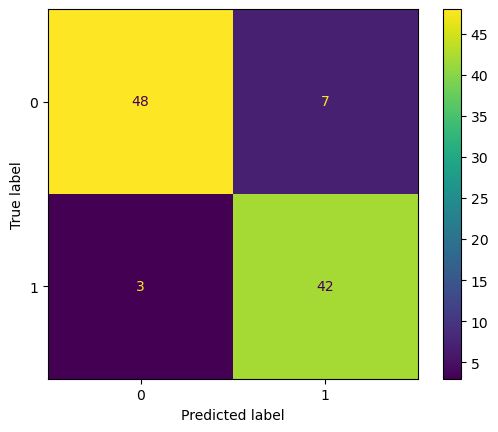

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test[:100], y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
